# Run 5808

- File 2857
- Taken on June 8th, 8 kV
- High Krypton rate

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-06-08 23:49:31


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from irotea.kr_plt_functions import plot_S12
from irotea.kr_plt_functions import plot_pmt_signals_vs_time_mus
from irotea.kr_plt_functions import plot_pmt_waveforms
from irotea.kr_plt_functions import plot_sipm_map
from irotea.kr_plt_functions import plot_cwf_vs_time_mus

In [7]:
from invisible_cities.icaro.mpl_functions import set_plot_labels

## NB functions

### Run Number and file number

In [8]:
run_number = 5808
file_number = '2857'

## Data base

In [9]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [10]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,23.1013,0.77,9.98610
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,24.5725,0.00,11.49370
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,27.4819,0.81,10.84410
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,27.9459,0.00,11.37120
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,33.3792,0.75,12.29650
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,23.4389,0.75,9.81317
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,28.0301,0.00,10.37830
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,35.3823,0.00,13.30200
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,25.6770,0.00,9.95530
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,28.2193,0.00,10.34620


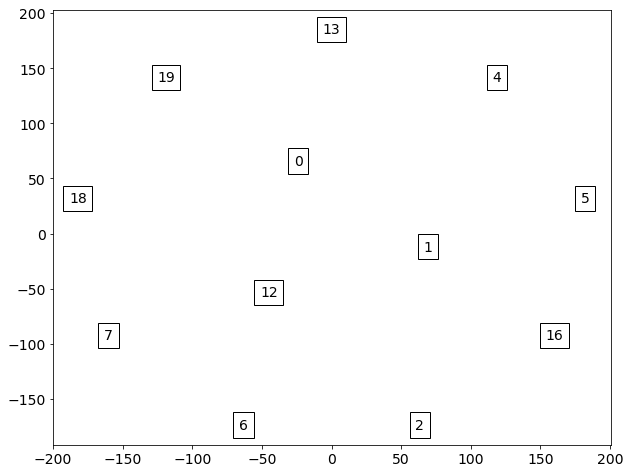

In [11]:
mpl.draw_pmt_map(run_number)

In [12]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [13]:
adc_to_pes

array([ 23.1013,  24.5725,  27.4819,  27.9459,  33.3792,  23.4389,
        28.0301,  35.3823,  25.677 ,  28.2193,  21.7387,  23.5544])

In [14]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

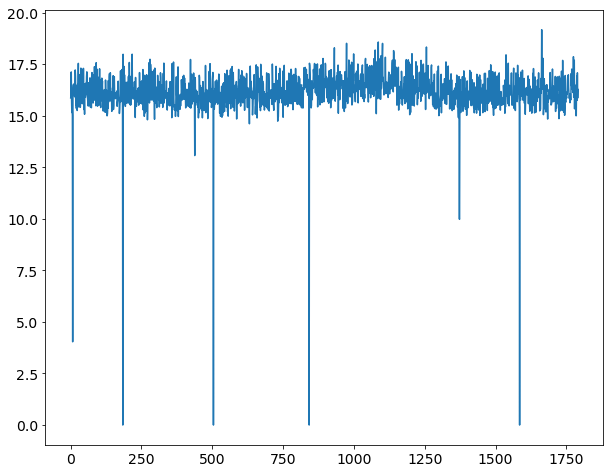

In [15]:
plt.plot(adc_to_pes_sipm)

### Opening file

In [16]:
filename = f'/Users/jjgomezcadenas/Projects/ICDEV/data/{run_number}/run_{run_number}_{file_number}_waveforms.h5'
print(f'opening filename {filename}')
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

opening filename /Users/jjgomezcadenas/Projects/ICDEV/data/5808/run_5808_2857_waveforms.h5


In [17]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
evts = h5rwf.root.Run.events[:]
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [40]:
s1params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 6,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [19]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event 0

In [20]:
event=0

In [21]:
evts[event]

(468549, 1528493718311)

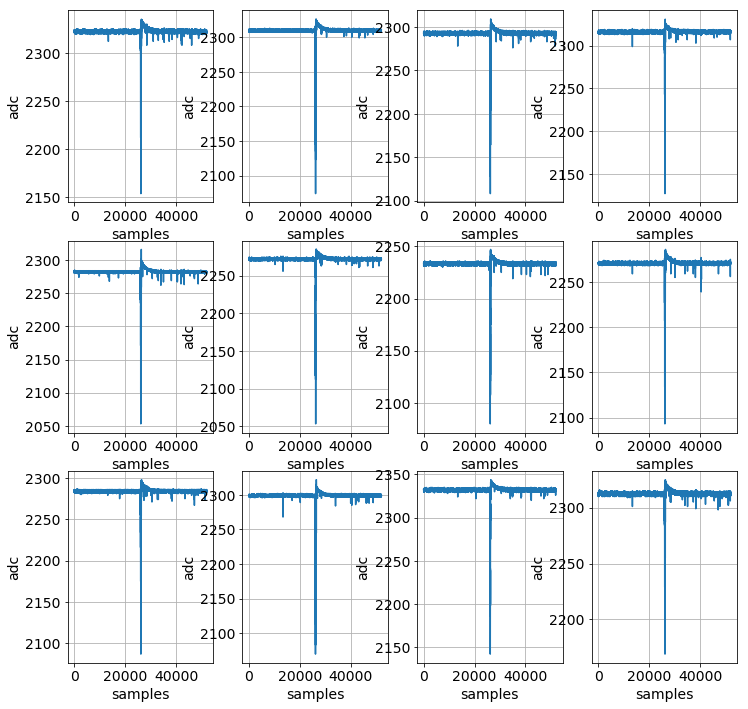

In [22]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

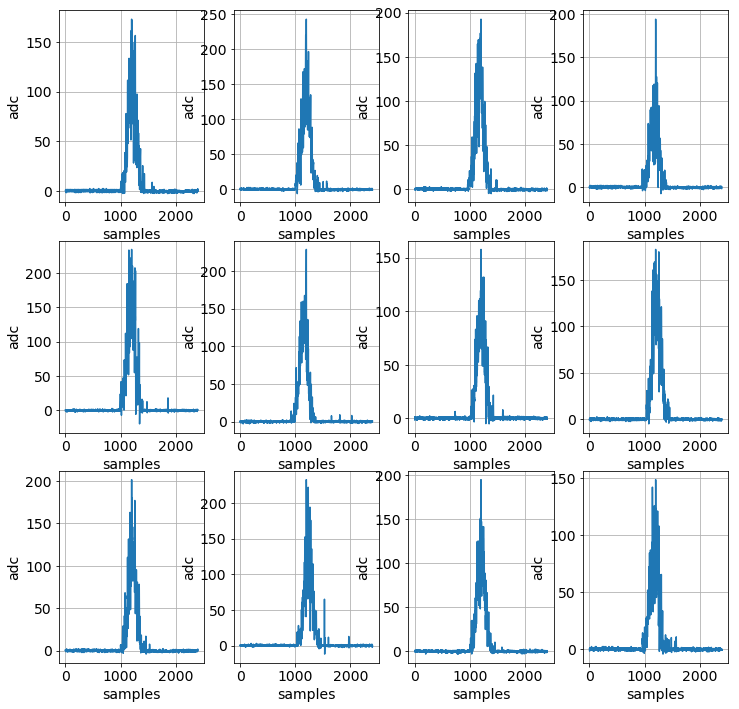

In [23]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [24]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

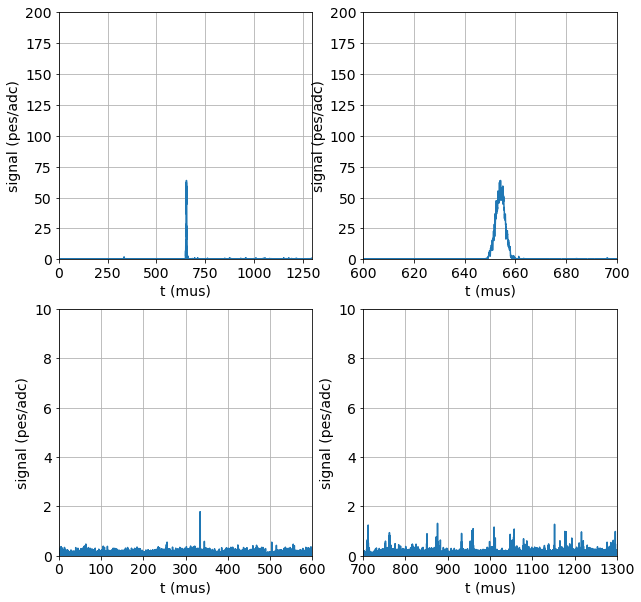

In [25]:
plot_cwf_vs_time_mus(cwf_sum,
                         t_min      =    0,
                         t_max      = 1300,
                         t_trg      = 650,
                         t_trgw     = 50,
                         s2_min =    0, 
                         s2_max =  200,
                         s1_min =    0, 
                         s1_max =  10,
                         figsize=(10,10))

In [44]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.8 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 334.075  334.1    334.125  334.15   334.175  334.2    334.225  334.25
 334.275] µs
       Time @ max energy: 334.2
       Width: 0.2 µs
       Height: 1.7854055731716898 pes
       Energy: 10.24908206697267 pes
       Charge: 0.0 pes
       RMS: 0.059022300760284155 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 334.45   334.475  334.5    334.525  334.55   334.575] µs
 Time @ max energy: 334.525
 Width: 0.125 µs
 Height: 1.6959950164856177 pes
 Energy: 7.3711972488417095 pes
 Charge: 0.0 pes
 RMS: 0.03915250870306801 µs]

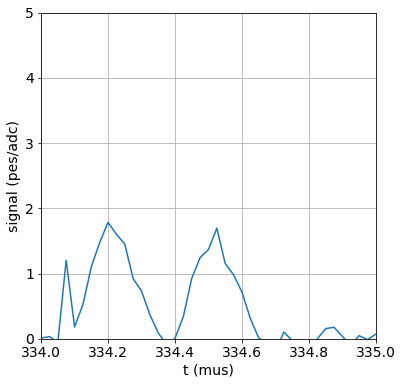

In [45]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =334,
                            t_max      = 335,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [46]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.9050248   650.90529064  651.89637102  652.85875523  653.85673704
 654.83374398  655.77491258  656.78027644  657.72154856  658.83621906] µs
       Time @ max energy: 653.8567370418539
       Width: 8.931194262901322 µs
       Height: 2158.269763654401 pes
       Energy: 10142.019949106654 pes
       Charge: 0.0 pes
       RMS: 1.7573809490070862 µs]

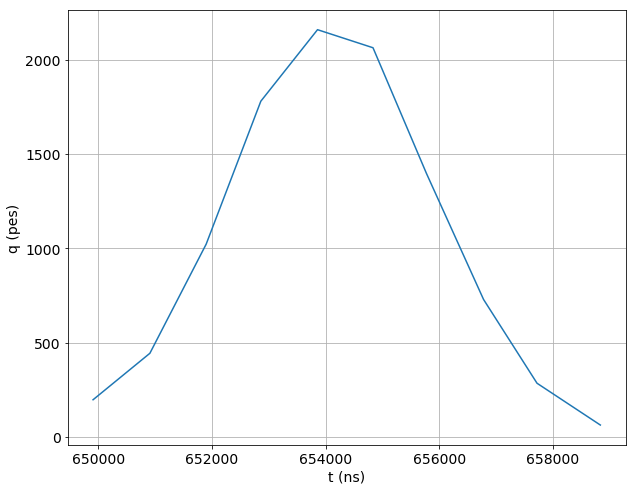

In [47]:
plot_S12(s2s)

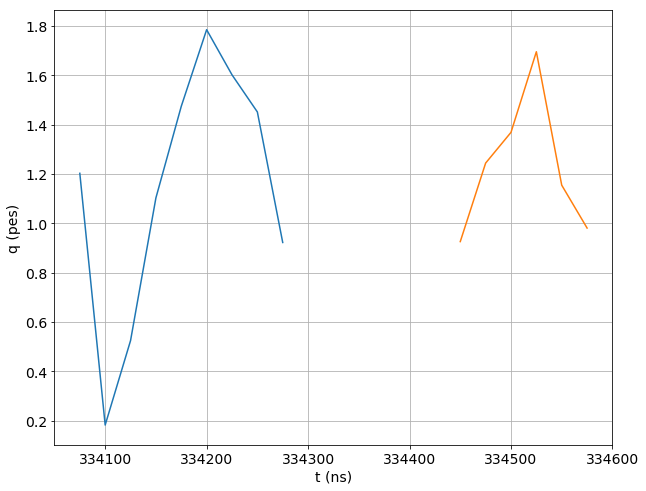

In [48]:
plot_S12(s1s)

In [49]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

[[   7]
 [ 412]
 [ 413]
 [ 419]
 [ 420]
 [ 421]
 [ 427]
 [ 428]
 [ 429]
 [ 436]
 [ 509]
 [ 943]
 [1207]]


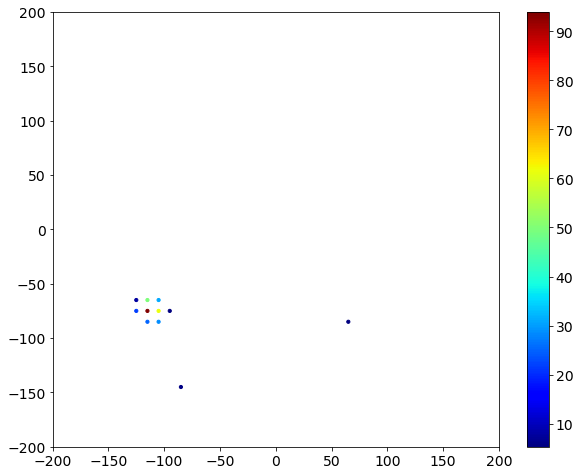

In [50]:
plot_sipm_map(sipm_cal, xs, ys)

## Event 1

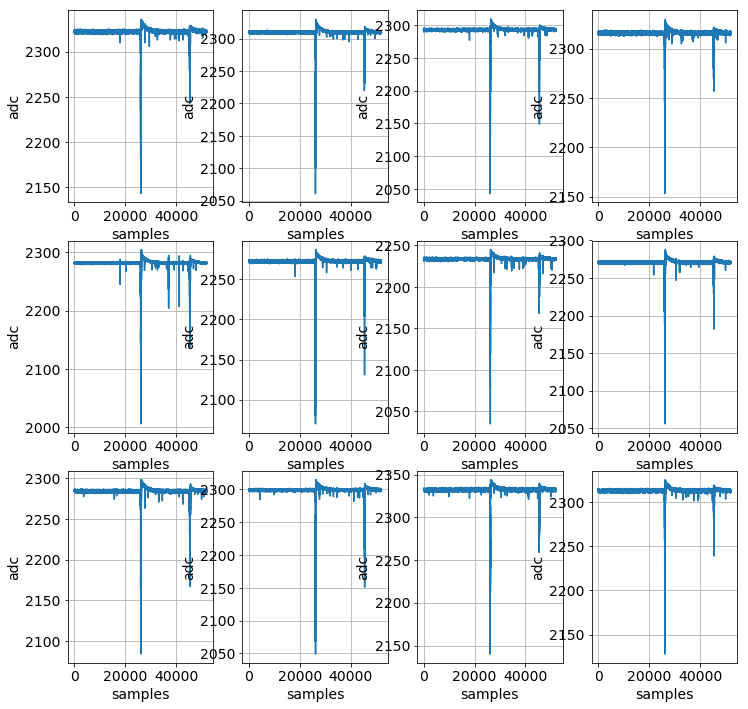

In [51]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

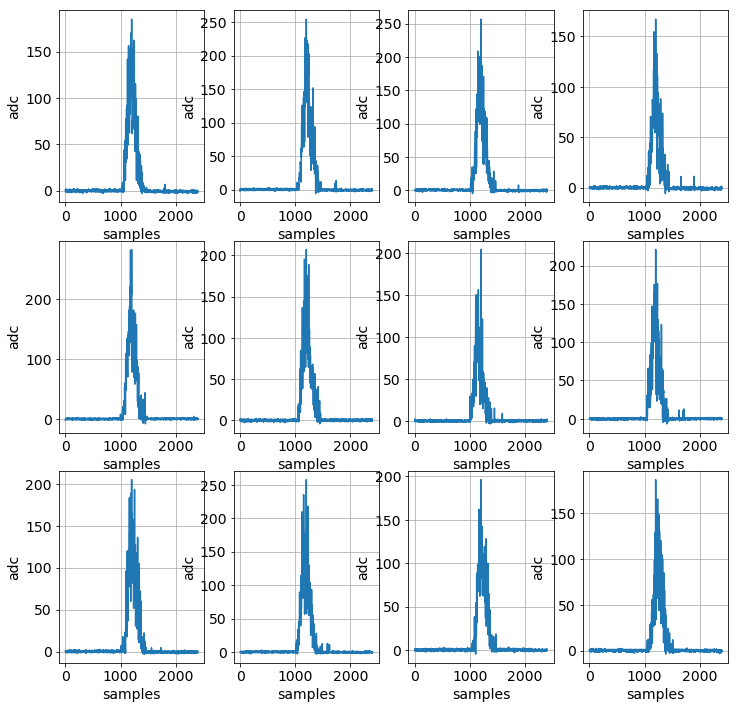

In [52]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [53]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

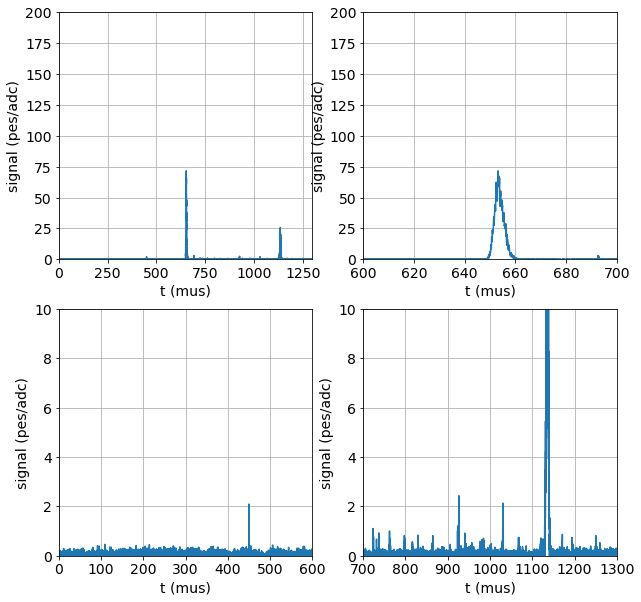

In [54]:
plot_cwf_vs_time_mus(cwf_sum,
                         t_min      =    0,
                         t_max      = 1300,
                         t_trg      = 650,
                         t_trgw     = 50,
                         s2_min =    0, 
                         s2_max =  200,
                         s1_min =    0, 
                         s1_max =  10,
                         figsize=(10,10))

In [55]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 449.475  449.5    449.525  449.55   449.575] µs
 Time @ max energy: 449.525
 Width: 0.1 µs
 Height: 2.094552826184714 pes
 Energy: 7.142729969536125 pes
 Charge: 0.0 pes
 RMS: 0.03053454587126515 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 449.825  449.85   449.875  449.9    449.925] µs
 Time @ max energy: 449.875
 Width: 0.1 µs
 Height: 1.0298929351856698 pes
 Energy: 3.409535481974916 pes
 Charge: 0.0 pes
 RMS: 0.03237812319949974 µs]

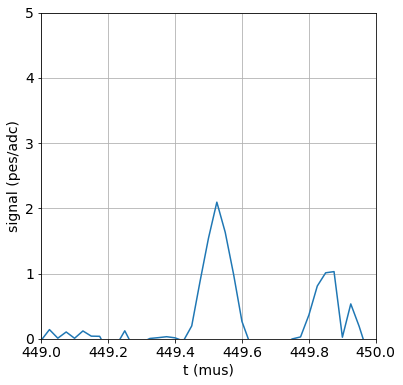

In [56]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =449,
                            t_max      = 450,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [59]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 649.87278652  650.85236231  651.80475337  652.78346868  653.73839954
 654.73180232  655.72536719  656.6807972   657.65503381  658.70338091
 659.6738567   660.36878115] µs
       Time @ max energy: 653.7383995414131
       Width: 10.495994627603912 µs
       Height: 2324.909122651342 pes
       Energy: 10741.091547091293 pes
       Charge: 0.0 pes
       RMS: 1.8004407137216385 µs]

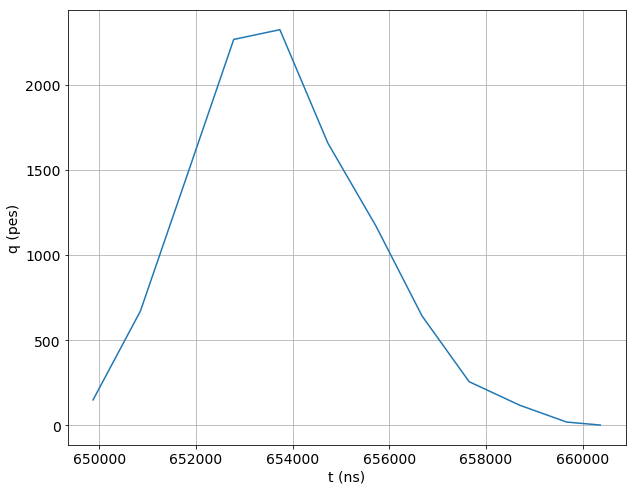

In [60]:
plot_S12(s2s)

[[   7]
 [1139]
 [1336]
 [1407]
 [1408]
 [1409]
 [1416]
 [1417]
 [1424]
 [1425]
 [1479]
 [1487]
 [1495]
 [1607]]


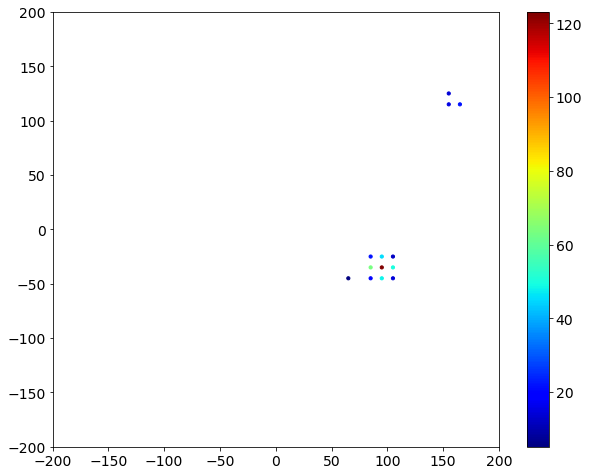

In [61]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 2

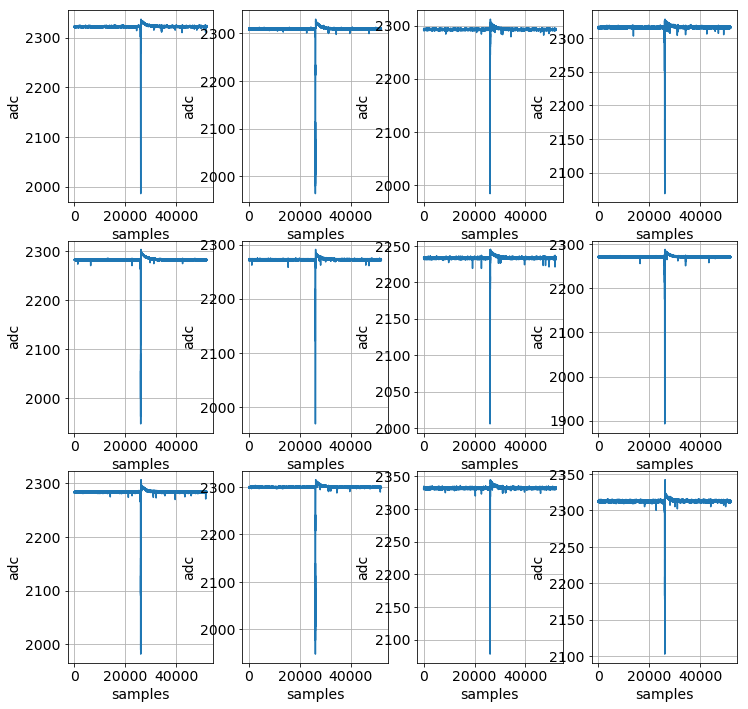

In [62]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

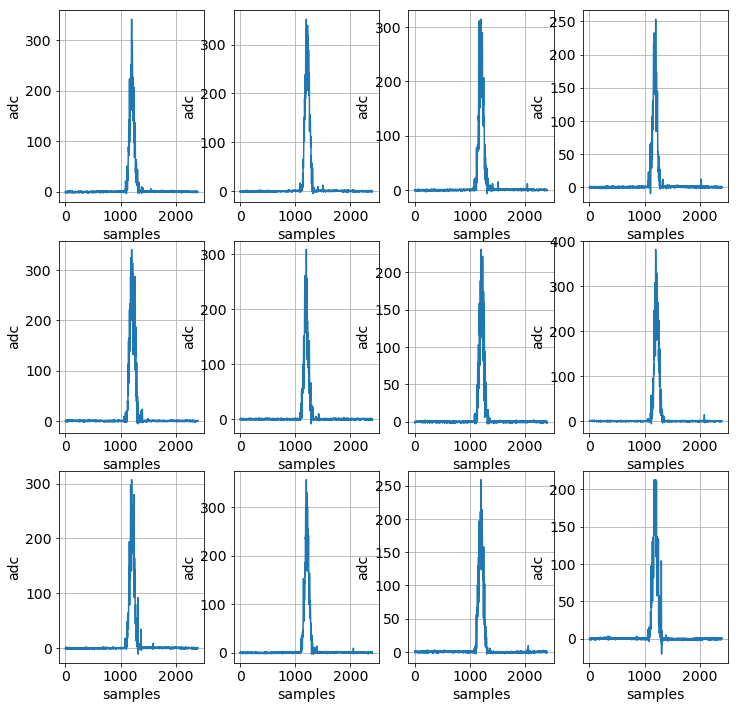

In [63]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [64]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

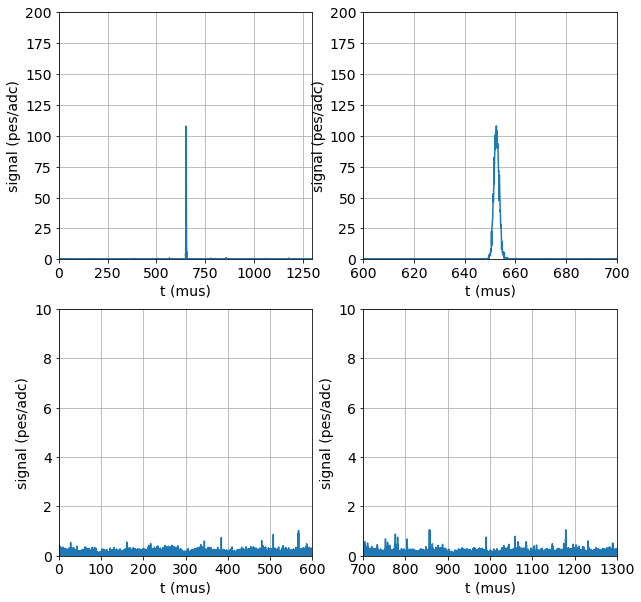

In [65]:
plot_cwf_vs_time_mus(cwf_sum)

In [66]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 567.025  567.05   567.075  567.1    567.125  567.15   567.175  567.2
 567.225  567.25   567.275] µs
       Time @ max energy: 567.05
       Width: 0.25 µs
       Height: 1.0263692410841356 pes
       Energy: 7.463555603571109 pes
       Charge: 0.0 pes
       RMS: 0.08337981237405001 µs]

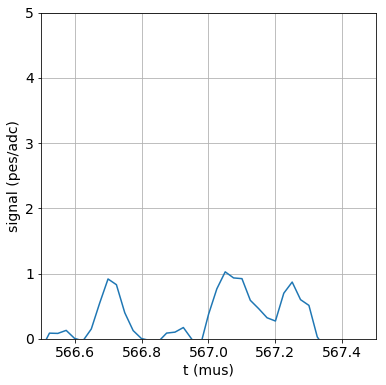

In [68]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =566.5,
                            t_max      = 567.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [69]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.98846132  650.97316362  651.87473423  652.7892566   653.73002429
 654.6542924   655.59132577  656.75923317] µs
       Time @ max energy: 652.7892565955325
       Width: 6.770771847832482 µs
       Height: 3797.359748935249 pes
       Energy: 10673.09192988147 pes
       Charge: 0.0 pes
       RMS: 0.9968240421103621 µs]

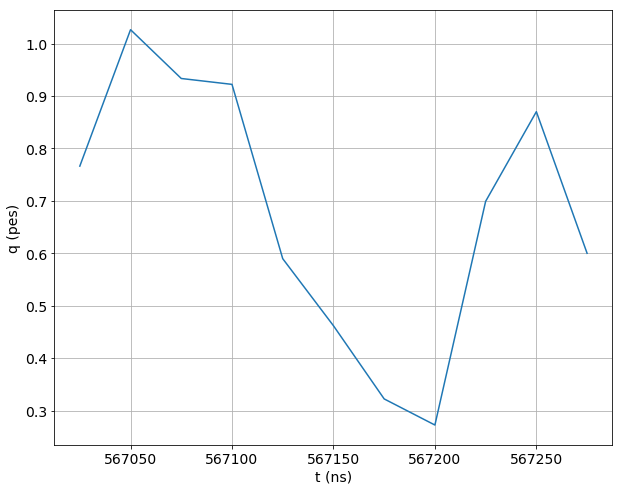

In [70]:
plot_S12(s1s)

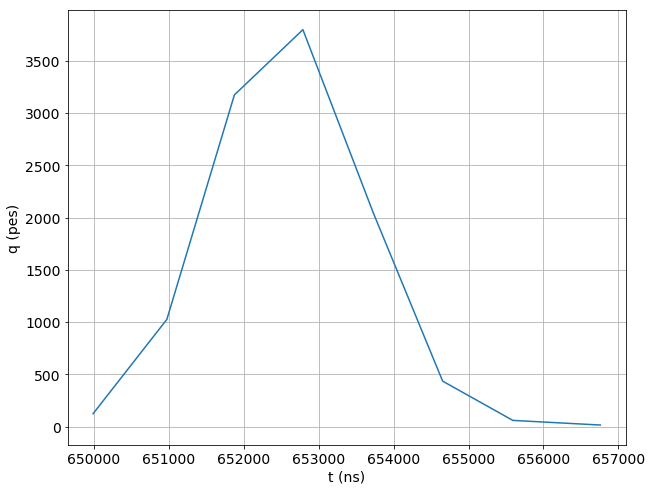

In [71]:
plot_S12(s2s)

[[   7]
 [ 120]
 [ 182]
 [ 183]
 [ 189]
 [ 190]
 [ 191]
 [ 320]
 [ 389]
 [ 390]
 [ 391]
 [ 398]
 [ 399]
 [1155]
 [1345]
 [1509]]


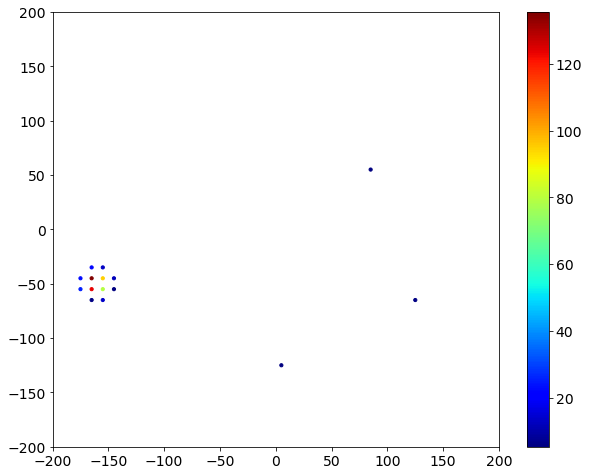

In [73]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 3

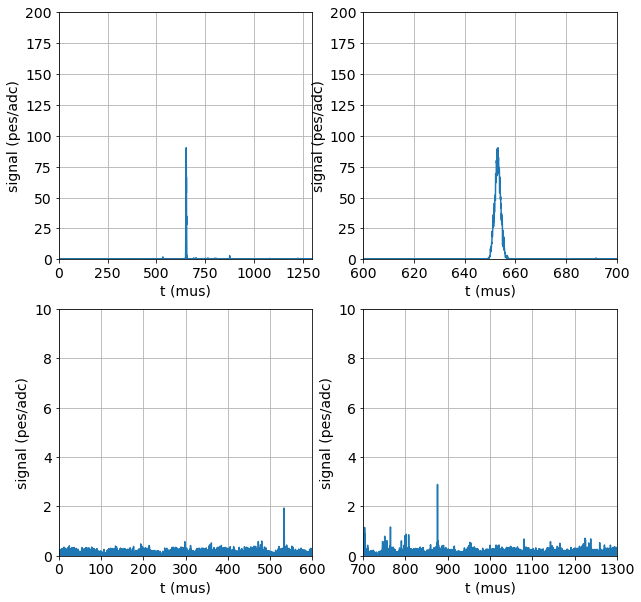

In [74]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [75]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 533.     533.025  533.05   533.075  533.1  ] µs
 Time @ max energy: 533.05
 Width: 0.1 µs
 Height: 1.9318147732937443 pes
 Energy: 7.170731395015372 pes
 Charge: 0.0 pes
 RMS: 0.032140527253510465 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 533.3    533.325  533.35   533.375  533.4    533.425  533.45 ] µs
 Time @ max energy: 533.35
 Width: 0.15 µs
 Height: 0.8454733543768884 pes
 Energy: 4.5349104164264515 pes
 Charge: 0.0 pes
 RMS: 0.04875042468204154 µs]

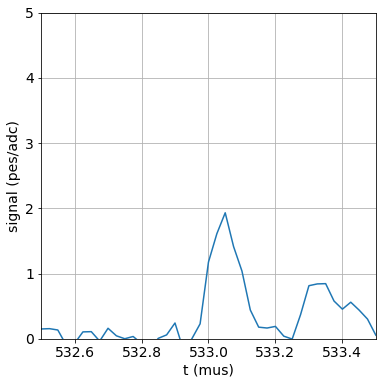

In [77]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =532.5,
                            t_max      = 533.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [79]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 650.25163334  651.152561    652.12750592  653.06121083  653.99733123
 654.95991344  655.88960264  656.84421485] µs
       Time @ max energy: 653.0612108257347
       Width: 6.592581513785873 µs
       Height: 3191.488205009777 pes
       Energy: 9695.780690838132 pes
       Charge: 0.0 pes
       RMS: 1.1875213233747537 µs]

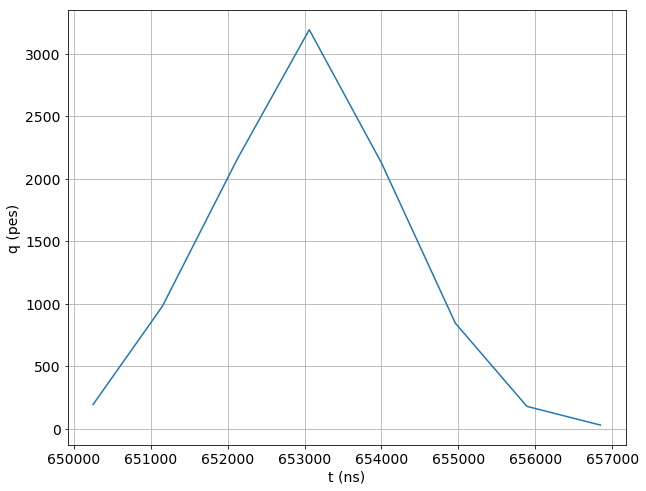

In [80]:
plot_S12(s2s)

[[   7]
 [ 216]
 [ 217]
 [ 224]
 [ 232]
 [ 278]
 [ 286]
 [ 287]
 [ 294]
 [ 295]
 [ 302]
 [ 303]
 [ 718]
 [1373]]


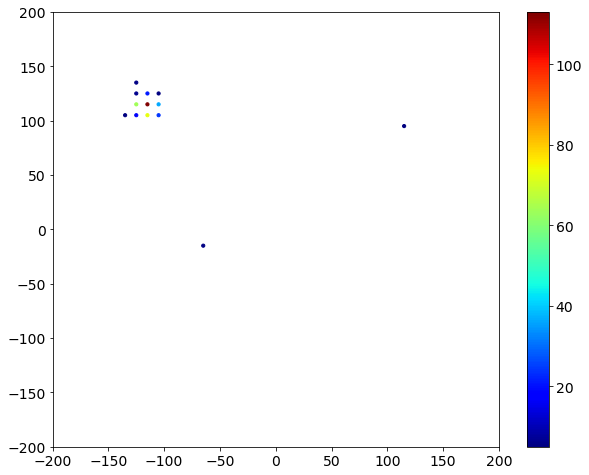

In [81]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 4

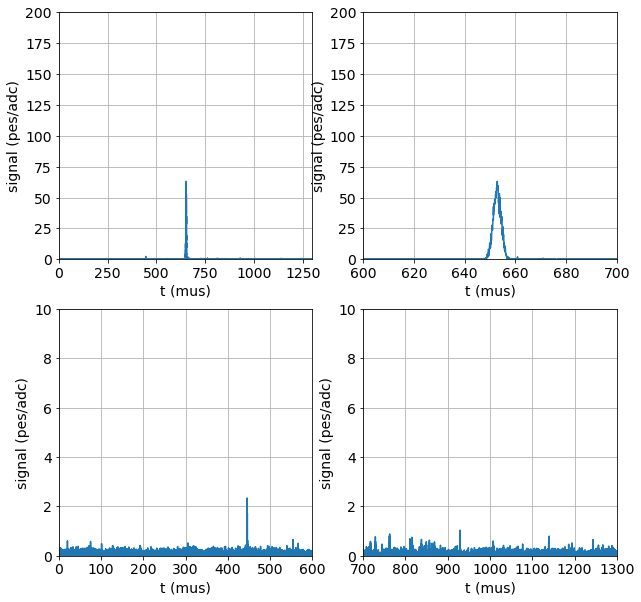

In [82]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [83]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

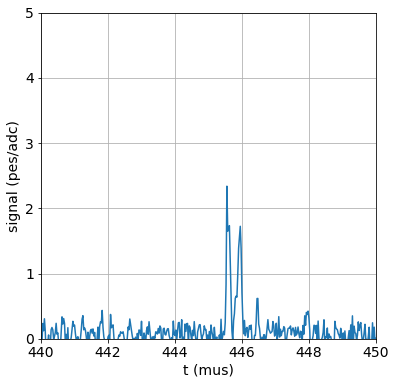

In [87]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =440,
                            t_max      = 450,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [88]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 648.9653005   649.91932527  650.8753901   651.84005364  652.81486252
 653.79205192  654.75252855  655.70008891  656.68213036  657.34907028] µs
       Time @ max energy: 652.8148625239056
       Width: 8.383769775525666 µs
       Height: 2266.0364654323052 pes
       Energy: 8643.875465183783 pes
       Charge: 0.0 pes
       RMS: 1.4945964865921613 µs]

[[   7]
 [ 459]
 [1468]
 [1665]
 [1666]
 [1667]
 [1668]
 [1673]
 [1674]
 [1675]
 [1676]
 [1682]
 [1683]]


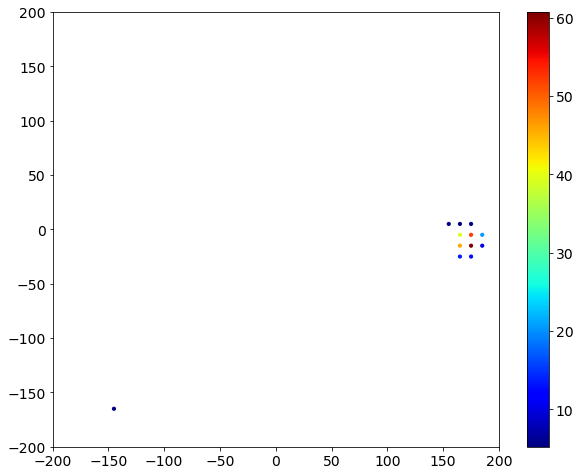

In [89]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 5

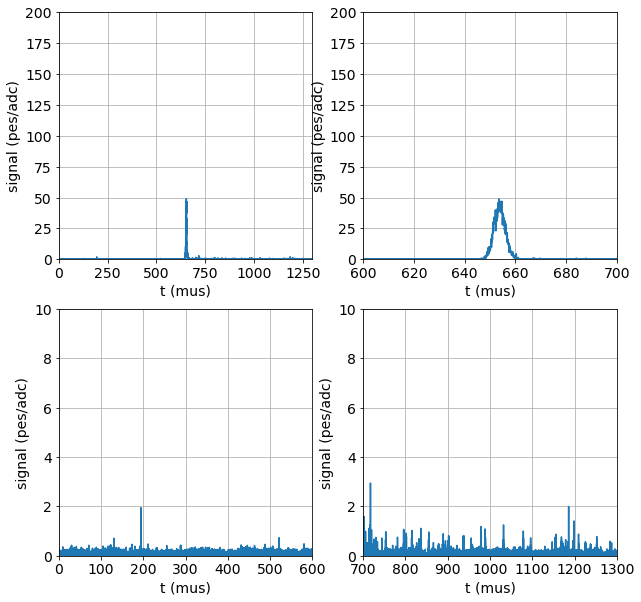

In [90]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [91]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 194.175  194.2    194.225  194.25   194.275] µs
 Time @ max energy: 194.225
 Width: 0.1 µs
 Height: 1.9468970231088092 pes
 Energy: 6.882642234851899 pes
 Charge: 0.0 pes
 RMS: 0.030895836841543567 µs]

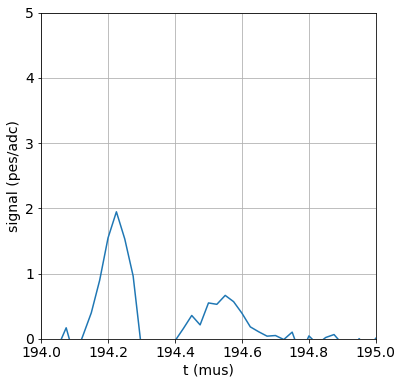

In [92]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =194,
                            t_max      = 195,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [93]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.06909872  649.04509186  650.05732101  651.05572933  651.99002319
 653.01535907  653.97824084  654.95738935  655.96379753  656.92429471
 657.92631313  658.90694898  659.97569386  660.81400704] µs
       Time @ max energy: 653.9782408444755
       Width: 12.744908322269795 µs
       Height: 1708.7464154823497 pes
       Energy: 9506.092632867318 pes
       Charge: 0.0 pes
       RMS: 2.2309761556494374 µs]

[[  7]
 [109]
 [280]
 [281]
 [288]
 [289]
 [296]
 [297]
 [304]
 [351]
 [359]
 [367]
 [434]
 [502]
 [508]]


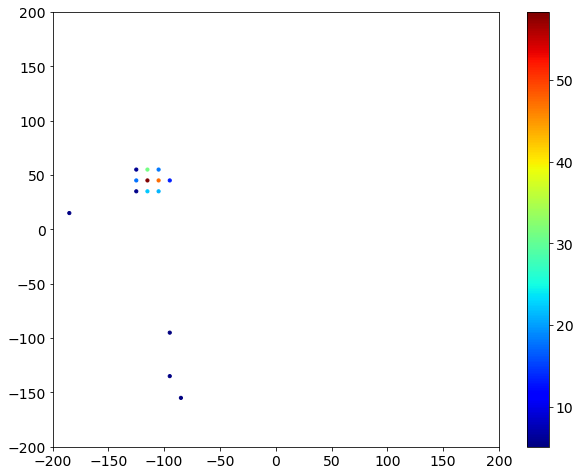

In [94]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 6

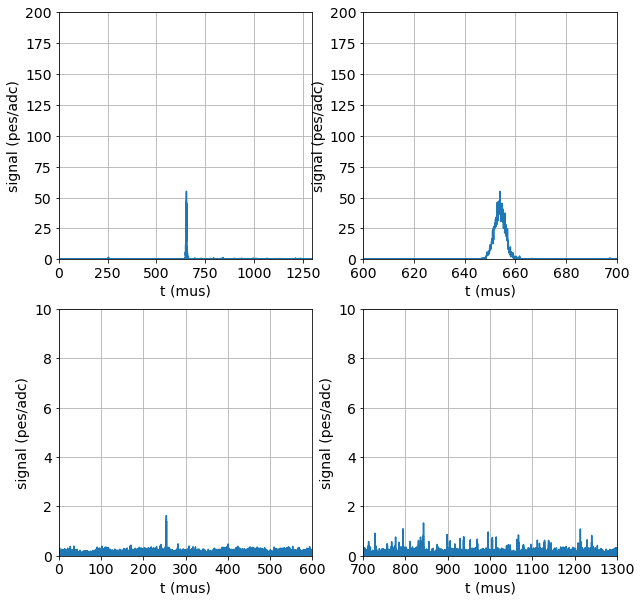

In [95]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [96]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 254.275  254.3    254.325  254.35   254.375  254.4  ] µs
 Time @ max energy: 254.325
 Width: 0.125 µs
 Height: 1.6244035682397653 pes
 Energy: 6.809631878618365 pes
 Charge: 0.0 pes
 RMS: 0.03557943330202627 µs]

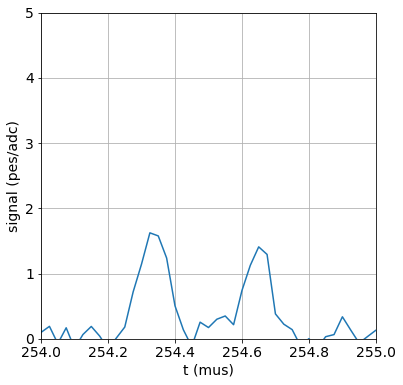

In [97]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =254,
                            t_max      = 255,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [98]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 648.24244119  649.10639733  650.1219758   651.09172979  652.07830772
 653.08751342  654.05561844  655.03841938  656.03270833  656.97309162
 658.00776278  658.98158385  660.14866877  661.36783659  661.64719844] µs
       Time @ max energy: 654.0556184373496
       Width: 13.404757249036221 µs
       Height: 1650.4426381006847 pes
       Energy: 8885.364151418062 pes
       Charge: 0.0 pes
       RMS: 2.127452640258282 µs]

[[   7]
 [1357]
 [1473]
 [1480]
 [1481]
 [1482]
 [1488]
 [1489]
 [1490]
 [1496]
 [1543]
 [1559]
 [1653]]


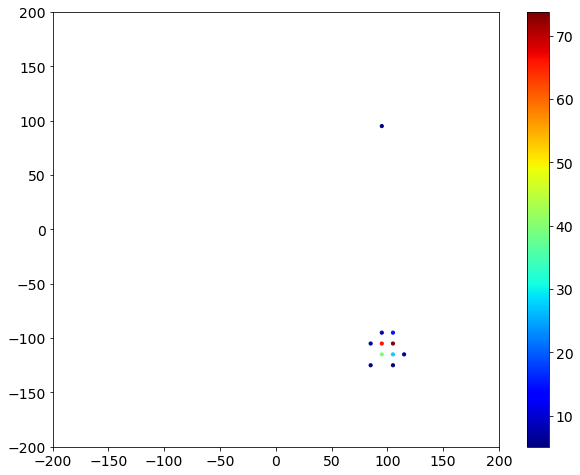

In [99]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 7

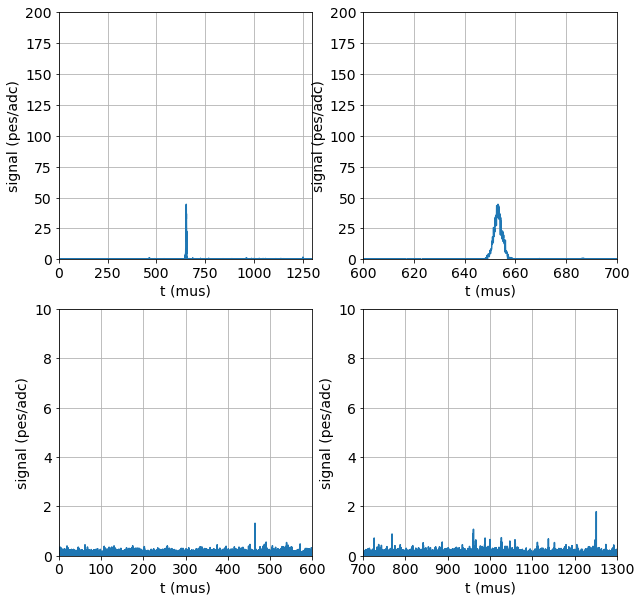

In [100]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [101]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 464.05   464.075  464.1    464.125  464.15 ] µs
 Time @ max energy: 464.125
 Width: 0.1 µs
 Height: 1.318257735847823 pes
 Energy: 4.617996548083492 pes
 Charge: 0.0 pes
 RMS: 0.03218943854607519 µs]

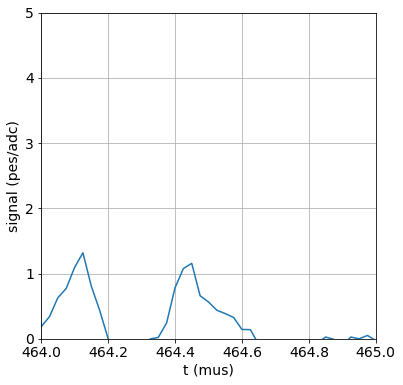

In [102]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =464,
                            t_max      = 465,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [103]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.16948453  650.09576824  651.0833248   652.0479161   653.01897194
 653.96479983  654.99483824  655.92342102  656.84425756  657.97022816
 658.525     ] µs
       Time @ max energy: 653.0189719423809
       Width: 9.35551547275926 µs
       Height: 1529.6974819110094 pes
       Energy: 6038.380849910699 pes
       Charge: 0.0 pes
       RMS: 1.6140242368294326 µs]

[[   7]
 [ 502]
 [ 731]
 [ 771]
 [ 891]
 [ 892]
 [ 893]
 [1219]
 [1220]
 [1221]
 [1227]
 [1228]
 [1229]
 [1504]]


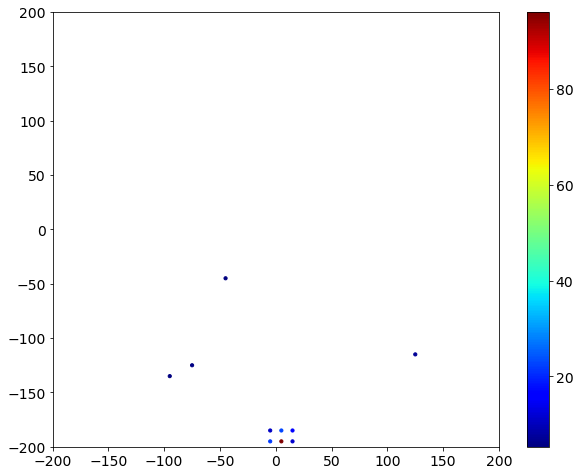

In [104]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 8

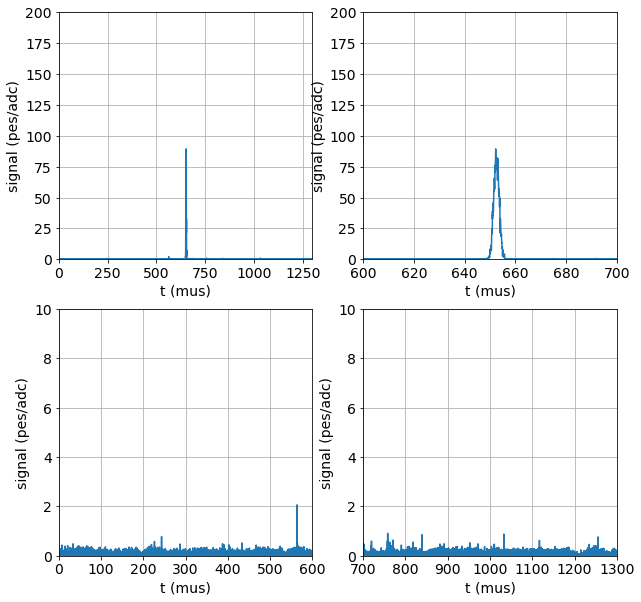

In [105]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [106]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 563.525  563.55   563.575  563.6    563.625] µs
 Time @ max energy: 563.55
 Width: 0.1 µs
 Height: 2.006772179323082 pes
 Energy: 5.568420798567682 pes
 Charge: 0.0 pes
 RMS: 0.030911398933189463 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 563.875  563.9    563.925  563.95   563.975  564.   ] µs
 Time @ max energy: 563.95
 Width: 0.125 µs
 Height: 1.0362224099681583 pes
 Energy: 4.550208965538416 pes
 Charge: 0.0 pes
 RMS: 0.038693052371552 µs]

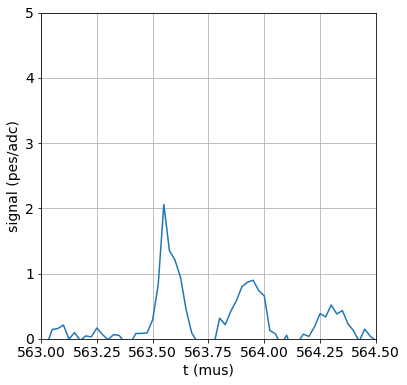

In [108]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =563,
                            t_max      = 564.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [110]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 7
       Times: [ 649.86813108  650.84694441  651.74413029  652.68185135  653.61059001
 654.55822722  655.47923893] µs
       Time @ max energy: 652.6818513462999
       Width: 5.611107850724599 µs
       Height: 3115.859218362312 pes
       Energy: 8919.630371903775 pes
       Charge: 0.0 pes
       RMS: 1.0356368762374955 µs]

[[   7]
 [ 259]
 [ 426]
 [ 609]
 [ 645]
 [1373]
 [1733]
 [1734]
 [1735]
 [1741]
 [1742]
 [1743]
 [1749]
 [1750]]


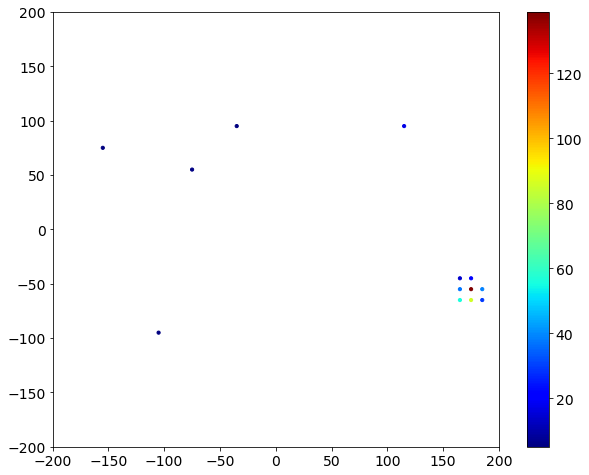

In [111]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 9

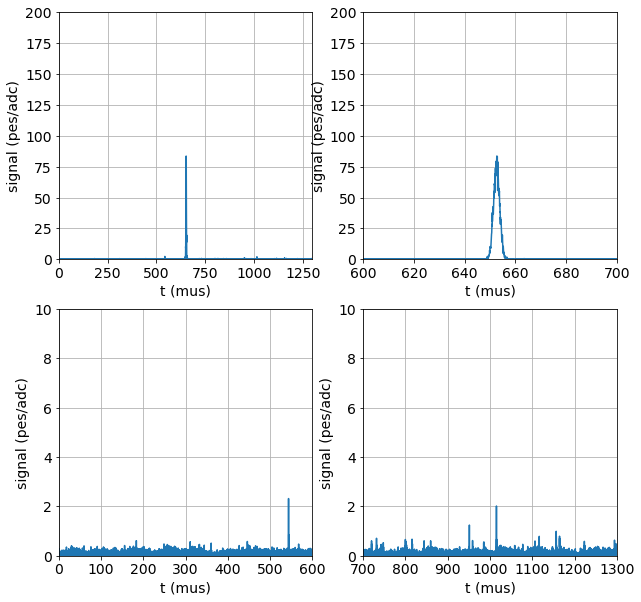

In [112]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [113]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 543.375  543.4    543.425  543.45   543.475  543.5    543.525] µs
 Time @ max energy: 543.425
 Width: 0.15 µs
 Height: 2.0754158034039802 pes
 Energy: 9.442706558071942 pes
 Charge: 0.0 pes
 RMS: 0.043160551326302504 µs]

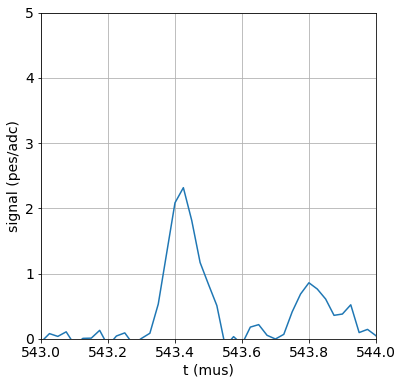

In [114]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =543,
                            t_max      = 544,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [115]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.54270243  650.52945137  651.44691974  652.41014842  653.34513867
 654.30661397  655.21852705  656.2523677 ] µs
       Time @ max energy: 652.4101484152472
       Width: 6.70966526900162 µs
       Height: 2895.3892572552277 pes
       Energy: 9175.31125379429 pes
       Charge: 0.0 pes
       RMS: 1.1743094874862188 µs]

[[   7]
 [1214]
 [1466]
 [1666]
 [1667]
 [1673]
 [1674]
 [1675]
 [1681]
 [1682]
 [1683]
 [1684]
 [1691]]


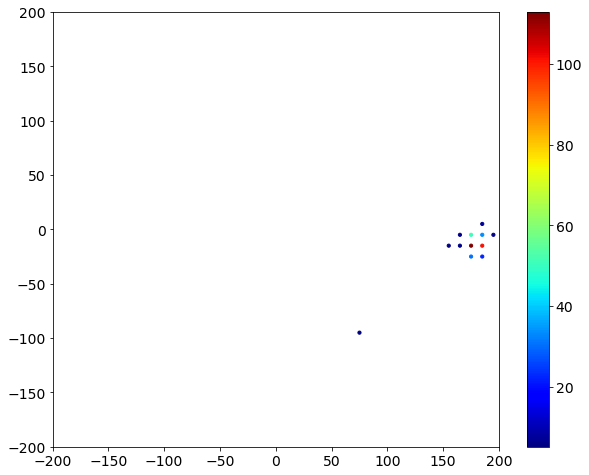

In [116]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

### Observations
- Many events with multiple S1. Perhaps increased grass due to high Krypton rate.